In [1]:
import sys

import numpy as np
import pandas as pd
from scipy.sparse.csgraph import connected_components
import torch
from torch_geometric.utils import degree, to_undirected, to_scipy_sparse_matrix
from torch_geometric.datasets import TUDataset
import matplotlib.pyplot as plt

In [2]:
def compute_commute_times(adj, P=0., to_return=('avg_commute_time',)):

    adj = to_undirected(adj.type(torch.int64))
    degrees = degree(adj[0], num_nodes=adj.max()+1)
    A = torch.zeros((degrees.size(0), degrees.size(0)))
    A[adj[0], adj[1]] = 1.
    num_connected_components = connected_components(A, directed=False, return_labels=False)
    assert num_connected_components == 1, f'num_connected_components = {num_connected_components}'

    L = torch.diag(degrees) - A
    L_pinv = torch.linalg.pinv(L)
    L_pinv_diag = torch.diag(L_pinv)
    
    beta = torch.sum(degrees / (1 - P**degrees))
    C = beta * (L_pinv_diag.unsqueeze(0) + L_pinv_diag.unsqueeze(1) - 2*L_pinv)
    C_flattened = torch.triu(C+1., diagonal=1).flatten()
    C_filtered = C_flattened[C_flattened > 0.] - 1.
    C_mean = torch.mean(C_filtered).item()

    if not to_return:
        return C_mean
    
    out = dict()
    if 'L' in to_return:
        out['L'] = L
    if 'C' in to_return:
        out['C'] = C
    if 'C_filtered' in to_return:
        out['C_filtered'] = C_filtered
    if 'C_mean' in to_return:
        out['C_mean'] = C_mean

    return out

In [8]:
adj = torch.Tensor([
    [0, 1, 2, 2, 3, 4],
    [1, 2, 3, 4, 5, 5]
])
print(compute_commute_times(adj, P=0., to_return=('C',)).get('C'))

tensor([[ 0.0000, 12.0000, 24.0000, 33.0000, 33.0000, 36.0000],
        [12.0000,  0.0000, 12.0000, 21.0000, 21.0000, 24.0000],
        [24.0000, 12.0000,  0.0000,  9.0000,  9.0000, 12.0000],
        [33.0000, 21.0000,  9.0000,  0.0000, 12.0000,  9.0000],
        [33.0000, 21.0000,  9.0000, 12.0000,  0.0000,  9.0000],
        [36.0000, 24.0000, 12.0000,  9.0000,  9.0000,  0.0000]])


In [18]:
adj = torch.Tensor([
    [0, 1],
    [1, 2]
])
print(compute_commute_times(adj, P=0.5, to_return=('C',)))
# [[ 0.0000,  6.6667, 13.3333],
# [ 6.6667,  0.0000,  6.6667],
# [13.3333,  6.6667,  0.0000]]

adj = torch.Tensor([
    [0, 1, 2],
    [1, 2, 0]
])
print(compute_commute_times(adj, P=0.5, to_return=('C',)))
# [[0.0000, 5.3333, 5.3333],
# [5.3333, 0.0000, 5.3333],
# [5.3333, 5.3333, 0.0000]]

adj = torch.Tensor([
    [0, 0, 0, 1, 1, 2],
    [1, 2, 3, 2, 3, 3]
])
print(compute_commute_times(adj, P=0.5, to_return=('C',)))
# [[0.0000, 6.8571, 6.8571, 6.8571],
# [6.8571, 0.0000, 6.8571, 6.8571],
# [6.8571, 6.8571, 0.0000, 6.8571],
# [6.8571, 6.8571, 6.8571, 0.0000]]

{'C': tensor([[ 0.0000,  6.6667, 13.3333],
        [ 6.6667,  0.0000,  6.6667],
        [13.3333,  6.6667,  0.0000]])}
{'C': tensor([[0.0000, 5.3333, 5.3333],
        [5.3333, 0.0000, 5.3333],
        [5.3333, 5.3333, 0.0000]])}
{'C': tensor([[0.0000, 6.8571, 6.8571, 6.8571],
        [6.8571, 0.0000, 6.8571, 6.8571],
        [6.8571, 6.8571, 0.0000, 6.8571],
        [6.8571, 6.8571, 6.8571, 0.0000]])}


In [9]:
dataset = TUDataset(root='./data', name='Proteins')
len(dataset)

1113

In [20]:
molecule = dataset[0]
result = compute_commute_times(molecule.edge_index, P=0., to_return=('C_filtered',))

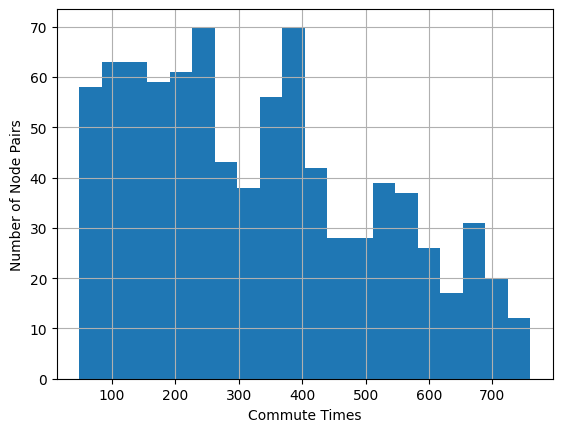

In [21]:
plt.hist(result['C_filtered'], bins=20)
plt.xlabel('Commute Times')
plt.ylabel('Number of Node Pairs')
plt.grid()
plt.show()

In [22]:
avg_commute_times = list()

for i in range(len(dataset)):
    molecule = dataset[i]
    try:
        result = compute_commute_times(molecule.edge_index, to_return=('C_mean'))
        avg_commute_times.append(result['C_mean'])
    except:
        print(
            f"i = {str(i).rjust(4, ' ')}: "
            f'{sys.exc_info()[0].__name__}({sys.exc_info()[1]}), ' +
            f'num_nodes = {molecule.num_nodes}'
        )

i =    5: AssertionError(num_connected_components = 8), num_nodes = 336
i =    6: AssertionError(num_connected_components = 4), num_nodes = 108
i =   20: AssertionError(num_connected_components = 8), num_nodes = 481
i =   87: AssertionError(num_connected_components = 3), num_nodes = 38
i =  149: AssertionError(num_connected_components = 2), num_nodes = 44
i =  154: AssertionError(num_connected_components = 2), num_nodes = 58
i =  190: AssertionError(num_connected_components = 6), num_nodes = 189
i =  212: AssertionError(num_connected_components = 2), num_nodes = 43
i =  235: AssertionError(num_connected_components = 4), num_nodes = 116
i =  238: AssertionError(num_connected_components = 2), num_nodes = 43
i =  253: AssertionError(num_connected_components = 2), num_nodes = 27
i =  263: AssertionError(num_connected_components = 2), num_nodes = 48
i =  265: AssertionError(num_connected_components = 2), num_nodes = 40
i =  274: AssertionError(num_connected_components = 2), num_nodes = 33
i

In [26]:
i = 1095
molecule = dataset[i]

connected_components(to_scipy_sparse_matrix(molecule.edge_index), directed=False, return_labels=True)

(2, array([0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]))

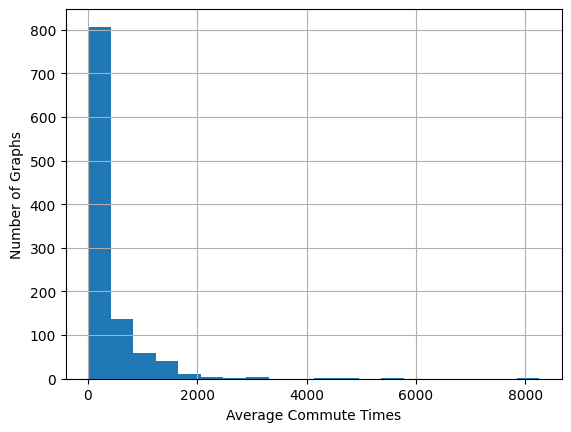

In [27]:
plt.hist(avg_commute_times, bins=20)
plt.xlabel('Average Commute Times')
plt.ylabel('Number of Graphs')
plt.grid()
plt.show()